In [1]:
import os
os.chdir("D:\\workspace\\git\\Kaggle\\House-Prices_Advanced-Regression-Techniques")
os.getcwd()

'D:\\workspace\\git\\Kaggle\\House-Prices_Advanced-Regression-Techniques'

In [2]:
#https://www.kaggle.com/humananalog/xgboost-lasso/code/code

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')

# The error metric: RMSE on the log of the sale prices.
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [3]:
# Load the data.
train_df = pd.read_csv("input/train.csv")
test_df = pd.read_csv("input/test.csv")
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
print('Shape of train_df : ', train_df.shape)
print('Shape of test_df : ', test_df.shape)

Shape of train_df :  (1460, 81)
Shape of test_df :  (1459, 80)


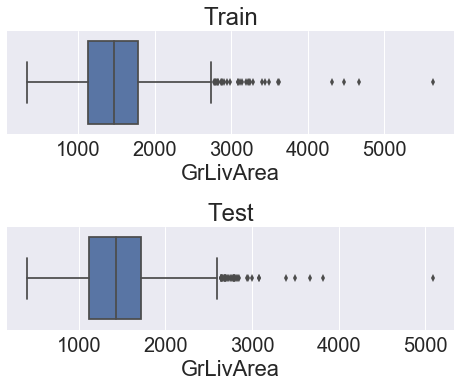

In [5]:
# Create a figure instance, and the two subplots
sns.set(font_scale=2)

fig = plt.figure()
plt.subplots_adjust(hspace = 0.9)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

sns.boxplot(train_df['GrLivArea'], ax=ax1).set_title("Train")
sns.boxplot(test_df['GrLivArea'], ax=ax2).set_title("Test")

In [6]:
# There are a few houses with more than 4000 sq ft living area that are
# outliers, so we drop them from the training data. (There is also one in
# the test set but we obviously can't drop that one.)
train_df.drop(train_df[train_df["GrLivArea"] > 4000].index, inplace=True)

In [7]:
print(test_df[test_df['GrLivArea']>4000].index[0])
#test_df[test_df['GrLivArea']>4000]

1089


In [8]:
list(set(train_df.columns.values) - set(test_df.columns.values))

['SalePrice']

In [9]:
test_df['SalePrice'] = 0
test_df['memo'] = 'test'
train_df['memo'] = 'train'
total_df = train_df.append(test_df, ignore_index=True)

In [10]:
print("")
print("num of rows: ", total_df.shape[0])
print("")
print("=====================")
print("")
ttl_check_na = total_df.isnull().sum()
ttl_check_na[ttl_check_na>0]


num of rows:  2915




MSZoning           4
LotFrontage      486
Alley           2717
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2907
Fence           2345
MiscFeature     2810
SaleType           1
dtype: int64

In [11]:
ttl_check_na[ttl_check_na / total_df.shape[0]>0.4]

Alley          2717
FireplaceQu    1420
PoolQC         2907
Fence          2345
MiscFeature    2810
dtype: int64

In [12]:
total_df.loc[total_df['Alley'].isnull(), 'Alley'] = 'none'
total_df.loc[total_df['FireplaceQu'].isnull(), 'FireplaceQu'] = 'none'
total_df.loc[total_df['PoolQC'].isnull(), 'PoolQC'] = 'none'
total_df.loc[total_df['Fence'].isnull(), 'Fence'] = 'none'
total_df.loc[total_df['MiscFeature'].isnull(), 'MiscFeature'] = 'none'

In [13]:
total_df.isnull().sum()[total_df.isnull().sum()>0]

MSZoning          4
LotFrontage     486
Utilities         2
Exterior1st       1
Exterior2nd       1
MasVnrType       24
MasVnrArea       23
BsmtQual         81
BsmtCond         82
BsmtExposure     82
BsmtFinType1     79
BsmtFinSF1        1
BsmtFinType2     80
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
Electrical        1
BsmtFullBath      2
BsmtHalfBath      2
KitchenQual       1
Functional        2
GarageType      157
GarageYrBlt     159
GarageFinish    159
GarageCars        1
GarageArea        1
GarageQual      159
GarageCond      159
SaleType          1
dtype: int64

In [14]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for col in total_df.columns.values[total_df.dtypes==object]:
    #total_df[col] = pd.factorize(total_df[col])[0]
    #total_df[col] = total_df[col].astype('category')
    le.fit(list(total_df[col][total_df[col].notnull()].values))
    total_df[col][total_df[col].notnull()] = le.transform(total_df[col][total_df[col].notnull()])

D:\wjhong\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
#https://chrisalbon.com/machine-learning/random_forest_classifier_example_scikit.html
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_jobs=2000, random_state=0)

In [16]:
#list( - set(test_df.columns.values))
features = list(set(total_df.columns)- set(['MSZoning', 'Id', 'memo', 'SalePrice']) )
features = list(total_df[total_df['MSZoning'].isnull()][features].dropna(1).columns.values)
y = total_df[features+ ['MSZoning']].dropna()['MSZoning']

In [17]:
clf.fit(total_df[features+ ['MSZoning']].dropna()[features], list(y))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=2000, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [18]:
clf.predict(total_df[total_df['MSZoning'].isnull()][features])

array([3, 3, 4, 3])

In [19]:
total_df[total_df['MSZoning'].isnull()]['MSZoning']

1911    NaN
2212    NaN
2246    NaN
2900    NaN
Name: MSZoning, dtype: object

In [20]:
## Using random forest to fill na.
for col in list(total_df.isnull().sum()[total_df.isnull().sum()>0].index):
    features = list(set(total_df.columns)- set([col, 'Id', 'memo', 'SalePrice']) )
    features = list(total_df[total_df[col].isnull()][features].dropna(1).columns.values)
    y = total_df[features+ [col]].dropna()[col]
    clf.fit(total_df[features+ [col]].dropna()[features], list(y))
    total_df.loc[total_df[col].isnull(), col] = clf.predict(total_df[total_df[col].isnull()][features])

In [21]:
total_df.isnull().sum()[ total_df.isnull().sum()>0 ]

Series([], dtype: int64)

In [22]:
for col in total_df.columns.values[total_df.dtypes==object]:
    total_df[col] = total_df[col].astype(int)

In [23]:
train_df = total_df[total_df['memo']==1]
test_df = total_df[total_df['memo']==0]
del test_df['SalePrice'], test_df['memo'], train_df['memo']

In [24]:
label_df = pd.DataFrame(index = train_df.index, columns=["SalePrice"])
label_df["SalePrice"] = np.log(train_df["SalePrice"])

In [25]:
#https://stackoverflow.com/questions/33749735/how-to-install-xgboost-package-in-python-windows-platform/35119904#35119904
import xgboost as xgb

regr = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.01,
                 max_depth=4,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)

regr.fit(train_df.drop(['SalePrice'], axis=1), label_df)
xgb_y_pred= regr.predict(test_df)

D:\wjhong\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [26]:
np.set_printoptions(suppress=True)
np.logspace(-5, -0.5, 30)

array([ 0.00001   ,  0.00001429,  0.00002043,  0.00002921,  0.00004175,
        0.00005968,  0.00008532,  0.00012196,  0.00017433,  0.0002492 ,
        0.00035622,  0.00050921,  0.0007279 ,  0.0010405 ,  0.00148735,
        0.00212611,  0.0030392 ,  0.00434441,  0.00621017,  0.0088772 ,
        0.01268961,  0.01813931,  0.02592944,  0.03706513,  0.05298317,
        0.07573739,  0.10826367,  0.15475874,  0.22122163,  0.31622777])

In [27]:
## wronge...?

"""
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold

alphas = np.logspace(-4, -0.5, 30)
lasso_cv = LassoCV(alphas=alphas, random_state=0)
k_fold = KFold(30)

X = train_df.drop(['SalePrice'], axis=1).reset_index(drop=True)
y = label_df.reset_index(drop=True)

alpha_score = pd.DataFrame(columns=('k', 'alpha', 'score'))

for k, (train, test) in enumerate(k_fold.split(X, y)):
    lasso_cv.fit(X.iloc[train], y.iloc[train].values.ravel())
    alpha_score = alpha_score.append({'k':k, 'alpha':lasso_cv.alpha_, 'score':lasso_cv.score(X.iloc[test], y.iloc[test].values.ravel())}, ignore_index=True)
    print(k, ' '*10, end='\r')
    #print("[fold {0}] alpha: {1:.5f}, score: {2:.5f}".
     #     format(k, lasso_cv.alpha_, lasso_cv.score(X.iloc[test], y.iloc[test])))
"""
''

''

In [29]:
## maybe this way?
from sklearn.linear_model import LassoCV
#from sklearn.model_selection import KFold
from sklearn.cross_validation import KFold
from sklearn.linear_model import Lasso
alphas = np.logspace(-5, -0.5, 50)

X = train_df.drop(['SalePrice'], axis=1).reset_index(drop=True)
y = label_df.reset_index(drop=True)

#lasso_cv = LassoCV(alphas=alphas, random_state=0)
k_fold = KFold(X.shape[0], n_folds=50,)

alpha_score = pd.DataFrame(columns=('alpha', 'score'))
for alpha in alphas:
    lasso_cv = Lasso(alpha=alpha)
    for (train, test) in k_fold:
        lasso_cv.fit(X.iloc[train], y.iloc[train].values.ravel())
        alpha_score = alpha_score.append({'alpha':alpha, 'score':lasso_cv.score(X.iloc[test], y.iloc[test].values.ravel())}, ignore_index=True)
        #print(k, ' '*10, end='\r')
    #print("[fold {0}] alpha: {1:.5f}, score: {2:.5f}".
     #     format(k, lasso_cv.alpha_, lasso_cv.score(X.iloc[test], y.iloc[test])))

alpha_score.groupby(['alpha']).agg(['mean', 'count'])

score      
              mean count
alpha                   
0.000010  0.899956    50
0.000012  0.899974    50
0.000015  0.899995    50
0.000019  0.900021    50
0.000023  0.900051    50
0.000029  0.900089    50
0.000036  0.900132    50
0.000044  0.900183    50
0.000054  0.900238    50
0.000067  0.900298    50
0.000083  0.900371    50
0.000102  0.900431    50
0.000126  0.900466    50
0.000156  0.900453    50
0.000193  0.900358    50
0.000239  0.900132    50
0.000295  0.899783    50
0.000364  0.899566    50
0.000450  0.899525    50
0.000556  0.899383    50
0.000687  0.899172    50
0.000848  0.898947    50
0.001048  0.898714    50
0.001295  0.898433    50
0.001600  0.897924    50
0.001977  0.897426    50
0.002442  0.896639    50
0.003017  0.895621    50
0.003728  0.894774    50
0.004605  0.894429    50
0.005690  0.893993    50
0.007030  0.893472    50
0.008685  0.892588    50
0.010730  0.891608    50
0.013257  0.890126    50
0.016379  0.887731    50
0.020236  0.884291    50
0.025001  0.879283    50
0.030888  0.871518    50
0.038162  0.862164    50
0.047149  0.848756    50
0.058251  0.835205    50
0.071969  0.829168    50
0.088916  0.829171    50
0.109854  0.829108    50
0.135723  0.828865    50
0.167683  0.828503    50
0.207170  0.828190    50
0.255955  0.827533    50
0.316228  0.826802    50

In [30]:
from sklearn.linear_model import Lasso

# Best alpha through cross-validation
best_alpha = 0.000126#0.00099

regr = Lasso(max_iter=50000)#Lasso(alpha=best_alpha, max_iter=50000)
regr.fit(train_df.drop(['SalePrice'], axis=1), label_df)

lasso_y_pred = regr.predict(test_df)

In [31]:
y_pred = (xgb_y_pred + lasso_y_pred) / 2
y_pred = np.exp(y_pred)

pred_df = pd.DataFrame(np.exp(xgb_y_pred), index=test_df["Id"], columns=["SalePrice"])
pred_df.to_csv('output/xgb_output.csv', header=True, index_label='Id') #0.12521
pred_df = pd.DataFrame(np.exp(lasso_y_pred), index=test_df["Id"], columns=["SalePrice"])
pred_df.to_csv('output/lasso_output.csv', header=True, index_label='Id') #0.12530
pred_df = pd.DataFrame(y_pred, index=test_df["Id"], columns=["SalePrice"])
pred_df.to_csv('output/xgb_lasso_output.csv', header=True, index_label='Id') #0.12091